## Setup

In [1]:
!pip install torch==2.6.0 torchvision torchaudio


INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 62.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 113.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 120.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 82.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 95.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 104.4 MB/s eta 0:00:0000:0100:01
 

In [2]:
!pip install https://github.com/mjun0812/flash-attention-prebuild-wheels/releases/download/v0.3.12/flash_attn-2.8.0+cu124torch2.6-cp310-cp310-linux_x86_64.whl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 MB 107.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [flash-attn]2 [flash-attn]


In [3]:
!pip install -U trl>=0.9.6 transformers>=4.42 peft>=0.12.0 accelerate>=0.33.0 bitsandbytes>=0.43.3 datasets>=2.18 qwen-vl-utils pillow


In [4]:
!pip install -U scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 109.2 MB/s eta 0:00:00a 0:00:01


In [5]:
!env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True,max_split_size_mb:64

KUBERNETES_SERVICE_PORT=443
KUBERNETES_PORT=tcp://10.43.0.1:443
MPLBACKEND=module://matplotlib_inline.backend_inline
HOSTNAME=npa0q5uec7
JUPYTER_TOKEN=2fc0304476e2ef9a87d28c0e75622900
HOME=/root
PAGER=cat
LC_CTYPE=C.UTF-8
PAPERSPACE_NOTEBOOK_REPO_ID=rpvbi2fcgpsvd8u
PAPERSPACE_CLUSTER_ID=clg07azjl
FORCE_COLOR=1
PIP_DISABLE_PIP_VERSION_CHECK=1
TERM=xterm-color
KUBERNETES_PORT_443_TCP_ADDR=10.43.0.1
PATH=/usr/local/texlive/2025/bin/x86_64-linux:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin
KUBERNETES_PORT_443_TCP_PORT=443
DISABLE_JUPYTER=true
KUBERNETES_PORT_443_TCP_PROTO=tcp
PAPERSPACE_METRIC_WORKLOAD_TYPE=notebook
DEBIAN_FRONTEND=noninteractive
CLICOLOR_FORCE=1
KUBERNETES_SERVICE_PORT_HTTPS=443
KUBERNETES_PORT_443_TCP=tcp://10.43.0.1:443
GIT_PAGER=cat
PAPERSPACE_FQDN=npa0q5uec7.clg07azjl.paperspacegradient.com
KUBERNETES_SERVICE_HOST=10.43.0.1
PWD=/notebooks
CLICOLOR=1
JPY_PARENT_PID=7
PAPERSPACE_NOTEBOOK_ID=npa0q5uec7
PYDEVD_USE_FRAME_EVAL=NO
NVIDIA_VISIBLE_DEVICES=GPU-8

In [6]:
import os, torch
from datasets import load_dataset
import torch.nn.functional as F
from transformers import (AutoProcessor, AutoTokenizer, BitsAndBytesConfig, EarlyStoppingCallback, LlavaNextForConditionalGeneration, LlavaNextProcessor)
from qwen_vl_utils import process_vision_info
from peft import LoraConfig, get_peft_model, PeftModel
from trl import SFTConfig, SFTTrainer
from PIL import Image, ImageOps
import re

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

In [2]:
# --------- Config ---------
MODEL_ID = "llava-hf/llama3-llava-next-8b-hf" 
DATASET_REPO = "AI-4-Everyone/Visual-TableQA"
OUTPUT_DIR   = "llava-hf-sft-lora-tableqa"

# --------- Load data ---------
ds = load_dataset(DATASET_REPO)

train = ds.get("train")

evald = ds.get("validation")


In [3]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from charts and diagrams images.
Answer the questions strictly from the image, with clear, rigorous step-by-step justification. Stay concise, but include all reasoning that’s relevant."""

In [4]:
def to_pil(img):
    return img if isinstance(img, Image.Image) else Image.fromarray(img)

In [1]:
def to_pil(img):
    return img if isinstance(img, Image.Image) else Image.fromarray(img)

def build_messages(sample):
    gt=sample["answer"]
    system= {"role": "system", "content": [{"type": "text", "text": system_message}]}
    user = {"role": "user", "content": [{"type":"image", "image": to_pil(sample['image'])}, {"type":"text","text": sample['question']}]}
    asst = {"role": "assistant", "content": [{"type":"text","text": gt}]}
    return [system, user], [system, user, asst]

def collate_fn(examples):
    msgs = [build_messages(example)[1] for example in examples]
    texts = [processor.apply_chat_template(m, tokenize=False) for m in msgs]

    image_inputs, _ = process_vision_info(msgs)
    batch = processor(
        text=texts,
        images=image_inputs,
        return_tensors="pt",
        padding=True,
        truncation=False,
        max_length=None,
    )

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100

    # mask image tokens
    image_token_ids = []
    for tok in ["<image>", "<im_patch>", "<im_start>", "<im_end>"]:
        tid = processor.tokenizer.convert_tokens_to_ids(tok)
        if tid != processor.tokenizer.unk_token_id and tid is not None:
            image_token_ids.append(tid)
    if image_token_ids:
        mask = torch.isin(labels, torch.tensor(image_token_ids, device=labels.device))
        labels[mask] = -100

    batch["labels"] = labels
    return batch


In [7]:
use_bf16 = torch.cuda.is_bf16_supported()

## Training

In [ ]:
model = LlavaNextForConditionalGeneration.from_pretrained(
    MODEL_ID,
    device_map="auto",
    torch_dtype=torch.bfloat16 if use_bf16 else torch.float16,
    low_cpu_mem_usage=True,
)

processor = AutoProcessor.from_pretrained(MODEL_ID)
model.config.use_cache = False
model.gradient_checkpointing_enable()
model.config.pretraining_tp = 1
processor.tokenizer.padding_side = "right"

In [15]:
# --------- LoRA config (r=16, alpha=8) ---------
TARGETS = "all-linear"

r, lora_alpha = 16, 8

peft_cfg = LoraConfig(r=r, lora_alpha=lora_alpha, lora_dropout=0.05, bias="none",
                      target_modules=TARGETS, task_type="CAUSAL_LM")

In [ ]:
# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_cfg)

# Print trainable parameters
peft_model.print_trainable_parameters()

In [17]:
# --------- SFT training args  ---------
args = SFTConfig(
    output_dir=OUTPUT_DIR,

    # dataset-sized schedule
    num_train_epochs=1,         
    per_device_train_batch_size=3,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,

    # stability & speed
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    bf16=use_bf16,
    fp16=not use_bf16,
    tf32=True,

    # optimization
    max_grad_norm=0.5,
    learning_rate=2e-5,           # LoRA-friendly; fits higher capacity
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    optim="adamw_torch_fused",      
    adam_beta1=0.9, adam_beta2=0.999,
    adam_epsilon=1e-8,
    weight_decay=0.1, #0.0,    
    
    # logging/eval/save: keep it simple on small data
    logging_steps=40,
    eval_strategy="steps", 
    eval_steps=100,
    save_strategy="steps",
    save_steps=100, 
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=3,
    
    remove_unused_columns=False,
    dataset_kwargs={"skip_prepare_dataset": True},
    dataset_text_field="",  #   # <- stops TRL from looking for "text"
)
callbacks = [EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)]

In [18]:
trainer = SFTTrainer(
    model=peft_model,
    args=args,
    train_dataset=train,
    eval_dataset=evald,
    data_collator=collate_fn,
    #peft_config=peft_cfg,
    callbacks=callbacks,
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model(OUTPUT_DIR)      # saves the adapters
processor.save_pretrained(OUTPUT_DIR)

#### Resume training

In [ ]:
trainer.train(resume_from_checkpoint=True)   

In [ ]:
trainer.save_model(OUTPUT_DIR)      # saves the adapters
processor.save_pretrained(OUTPUT_DIR)

## Final Model Loading and Inferance

In [13]:
processor = AutoProcessor.from_pretrained(MODEL_ID)

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [14]:
model = LlavaNextForConditionalGeneration.from_pretrained(
    MODEL_ID,
    device_map="auto",
    torch_dtype=torch.bfloat16 if use_bf16 else torch.float16,
    low_cpu_mem_usage=True,
)
processor = AutoProcessor.from_pretrained(MODEL_ID)

adapter_path = OUTPUT_DIR
model.load_adapter(adapter_path)

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


In [17]:
def generate_text_from_sample(model, sample, max_new_tokens=5000, device="cuda"):
    text_input = processor.apply_chat_template(build_messages(sample)[0], tokenize=False, add_generation_prompt=True)
    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(build_messages(sample)[0])
    # Prepare the inputs for the model
    model_inputs = processor(text=[text_input], images=image_inputs, return_tensors="pt").to(device)  # Move inputs to the specified device

    gen_kwargs = {"max_new_tokens":max_new_tokens, "do_sample":False, "pad_token_id": processor.tokenizer.pad_token_id, 
                  "eos_token_id": processor.tokenizer.eos_token_id}
    
    with torch.inference_mode():
        output_ids = model.generate(**model_inputs, **gen_kwargs)

    # Decode only the generated part (exclude input tokens)
    input_token_len = model_inputs["input_ids"].shape[1]
    generated_ids = output_ids[:, input_token_len:]
    
    # Decode the generated text
    generated_text = processor.decode(
        generated_ids[0], 
        skip_special_tokens=True, 
        clean_up_tokenization_spaces=True
    )
    
    return generated_text.strip()

In [18]:
output = generate_text_from_sample(model, processor, train[0])
output

'The orange-boxed Comprehensive Lighting Plan section acts as an overarching summary or integration point for the green-boxed sections (Natural, Studio, Specialty Lighting). The arrows from the Natural and Specialty lighting boxes to the Comprehensive Plan indicate that these specific setups feed into the broader plan, while the arrow from the Studio box to the Comprehensive Plan suggests that studio setups are also integrated into the overall plan. This hierarchical structure is visually represented by the orange box being positioned below the green boxes, with arrows pointing upwards towards it, signifying that the detailed setup information flows into the comprehensive plan.'

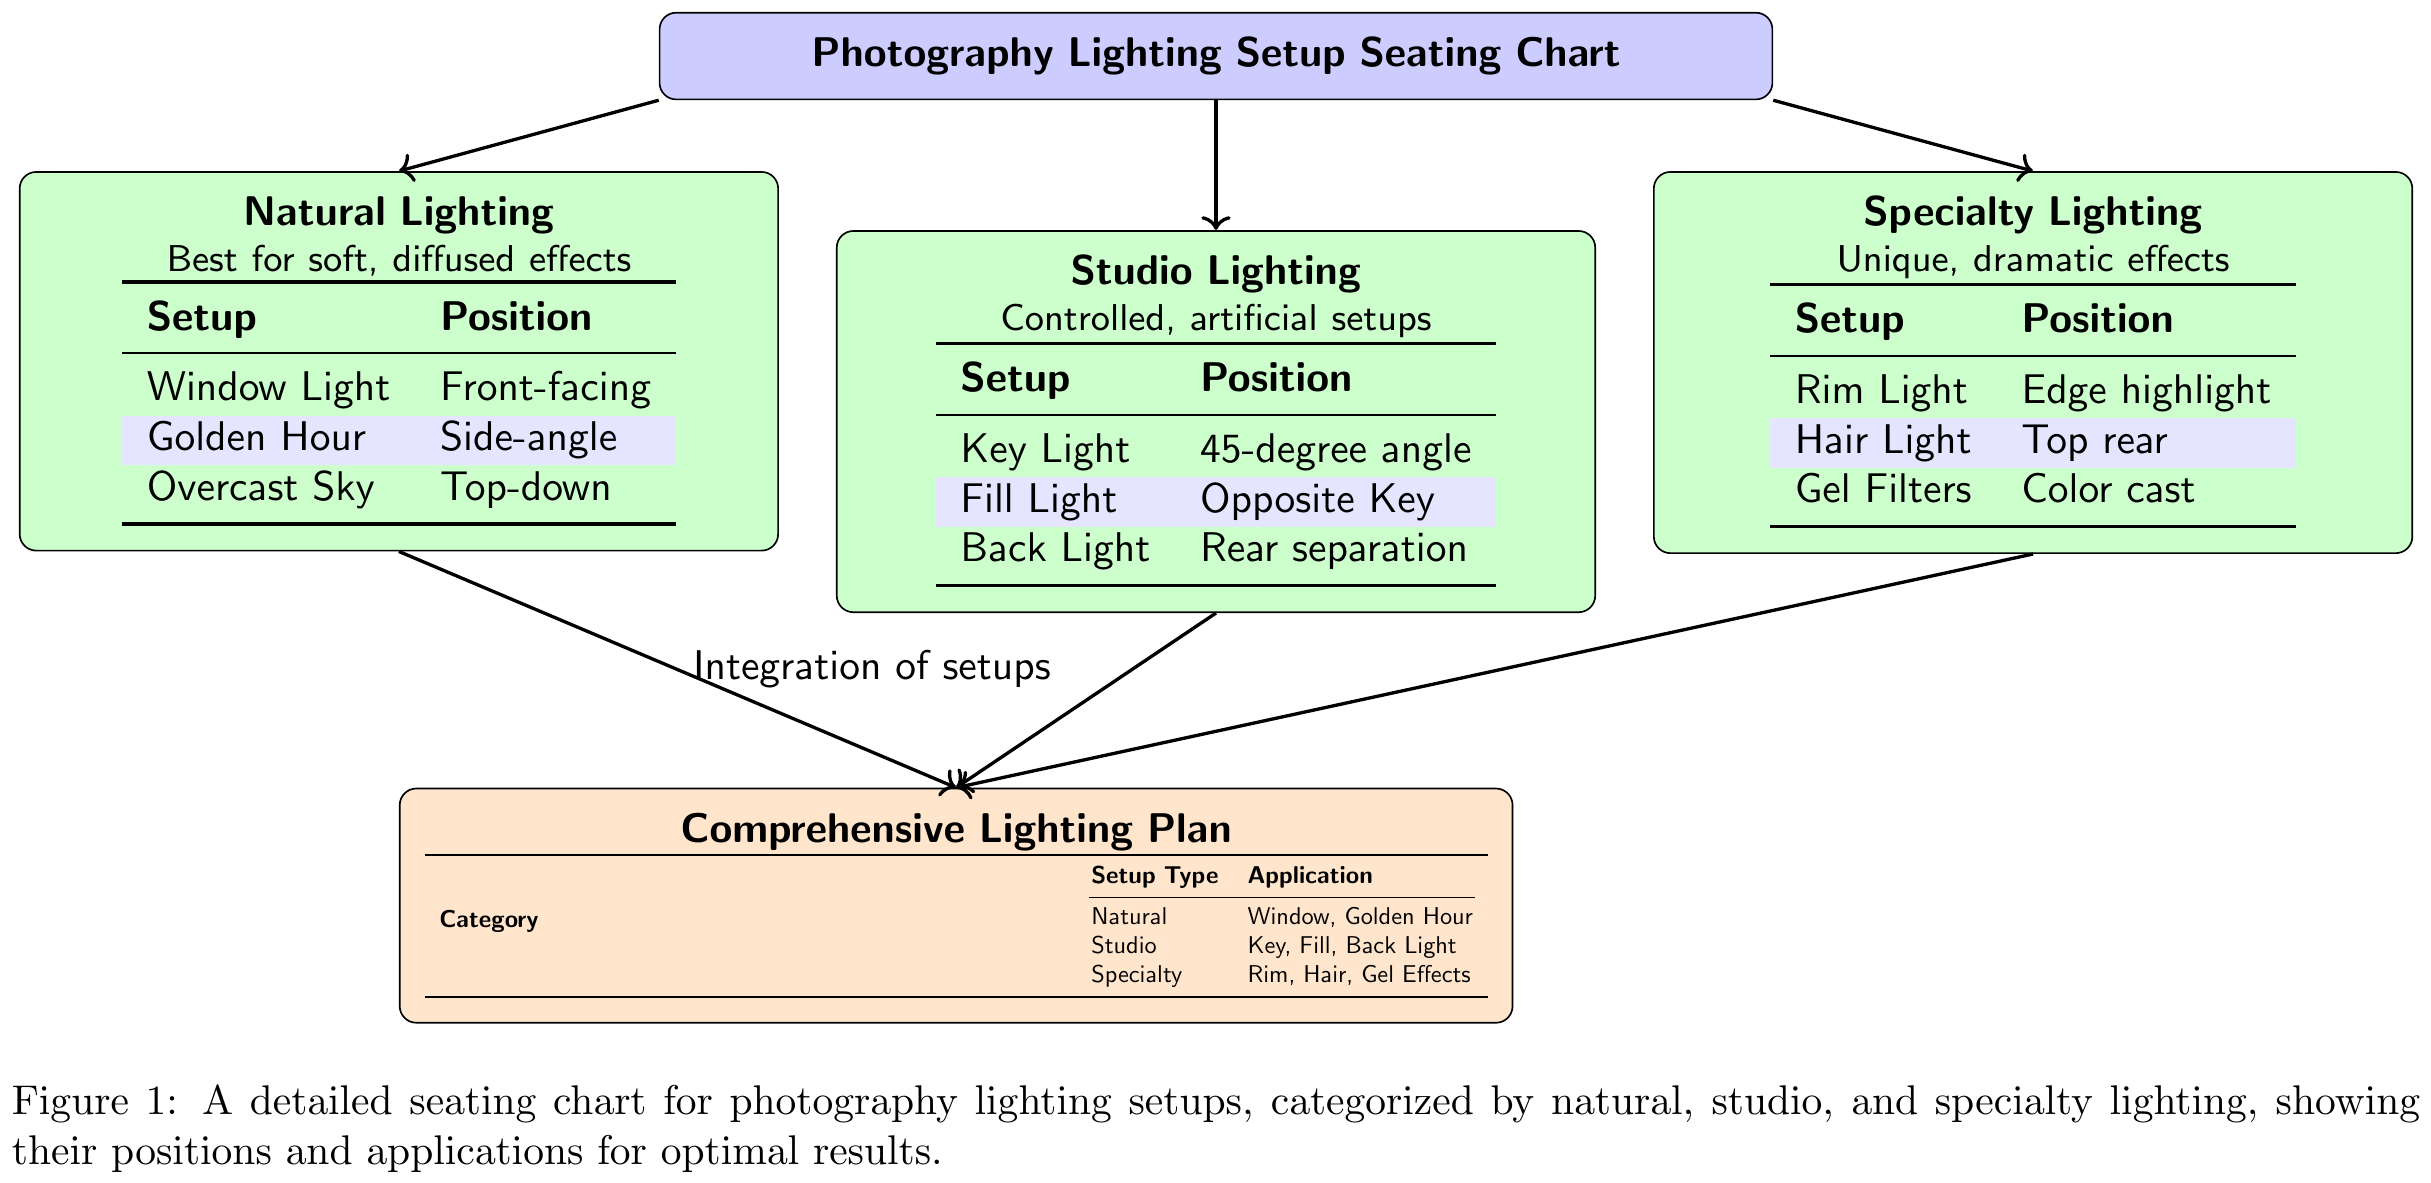

In [19]:
train[0]["image"]

In [20]:
train[0]["question"]

'Based on the color coding system used in the diagram, what is the hierarchical relationship between the orange-boxed section and the green-boxed sections, and how does this relate to the information flow shown by the arrows?'

In [22]:
train[0]["answer"]

"The color coding shows a clear hierarchical relationship where the orange-boxed 'Comprehensive Lighting Plan' serves as the final integration point, while the three green-boxed sections represent the source categories. The arrows flow from green (source/input) to orange (synthesis/output), indicating that the orange section consolidates and summarizes information from all green sections, representing a higher level of organization in the lighting setup hierarchy."

In [21]:
!nvidia-smi

Mon Sep 22 14:04:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:00:05.0 Off |                  Off |
| 35%   55C    P2             78W /  300W |   17093MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
